# Рекомендация тарифов

В распоряжении есть данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — данные обработаны.

Построим модель с максимально большим значением *accuracy*. Доведем долю правильных ответов по крайней мере до 0.75. Проверим *accuracy* на тестовой выборке.



<font size = 4> **Описание данных**</font>

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

<font size = 4> **Оглавление проекта:**</font>
- Откроем и изучим файл
- Разобьём данные на выборки
- Исследуем модели
- Проверим модель на тестовой выборке
- Проверим модель на адекватность

## Открываем и изучаем данные

Подключаем библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

Загрузим данные из файла users_behavior.csv, выведем первые 10 строк таблицы для первого взгляда на данные.
Также с помощью метода info() изучим структуру таблицы: типы данных, количество строк, столбцов, пропущенных данных.

In [2]:
# читаем данные из .csv файла с помощью метода read_csv()
users = pd.read_csv('/datasets/users_behavior.csv')
# выведем первые 10 строк таблицы с помощью метода head()
users.head(10)
# с помощью метода info() изучим структуры таблицы: типы данных, количество строк, столбцов, пропущенных данных.


calls  minutes  messages   mb_used  is_ultra
0   40.0   311.90      83.0  19915.42         0
1   85.0   516.75      56.0  22696.96         0
2   77.0   467.66      86.0  21060.45         0
3  106.0   745.53      81.0   8437.39         1
4   66.0   418.74       1.0  14502.75         0
5   58.0   344.56      21.0  15823.37         0
6   57.0   431.64      20.0   3738.90         1
7   15.0   132.40       6.0  21911.60         0
8    7.0    43.39       3.0   2538.67         1
9   90.0   665.41      38.0  17358.61         0

In [3]:
# с помощью метода info() изучим структуры таблицы: типы данных, количество строк, столбцов, пропущенных данных.
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В таблице данных 3214 объектов. Пропусков нет.
В столбцах calls и messages содержится целочисленная информация. Заменим тип данных в них на int64 для уменьшения занимаемого места.

In [4]:
users['calls'] = users['calls'].astype('int16')
users['messages'] = users['messages'].astype('int16')

Рассмотрим распределение данных

In [5]:
users.describe()

calls      minutes     messages       mb_used     is_ultra
count  3214.000000  3214.000000  3214.000000   3214.000000  3214.000000
mean     63.038892   438.208787    38.281269  17207.673836     0.306472
std      33.236368   234.569872    36.148326   7570.968246     0.461100
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%      40.000000   274.575000     9.000000  12491.902500     0.000000
50%      62.000000   430.600000    30.000000  16943.235000     0.000000
75%      82.000000   571.927500    57.000000  21424.700000     1.000000
max     244.000000  1632.060000   224.000000  49745.730000     1.000000

По всем признакам медиана и среднее значение не сильно отличаются друг от друга. Перекоса в данных почти не наблюдается.
Построим графики распределений признаков (гистограммы и boxplot)

In [6]:
def show_hists(data, data_label, num_bins, rug=False, log_scale=False):
    """
    input: data - данные для построения гистограммы
           data_label - описание данных
           num_bins - количество ячеек
    output: None
    description: Функция строит гистограмму и boxplot для выбранного параметра:
                - Плотность распределения (методом distplot() библиотеки seaborn)
                - Boxplot (метод boxplot() библиотеки seaborn)
    """
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label + ". Плотность распределения", fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.distplot(data, bins=num_bins, rug=rug, ax=axes[0])
    axes[1].set_title(data_label + ". Boxplot", fontsize=18)
    sns.boxplot(data=users, x=data_label, ax=axes[1])
    plt.show()

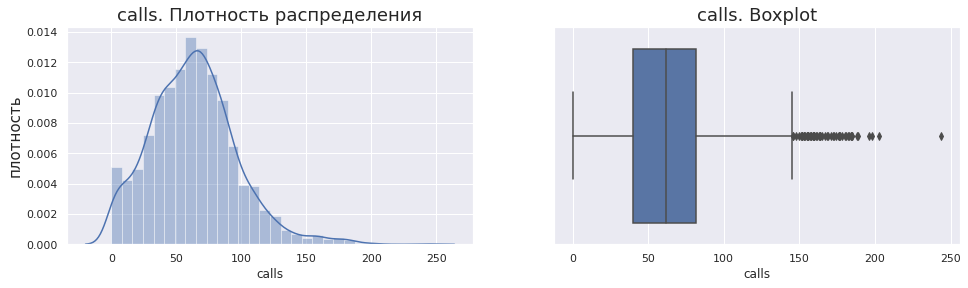

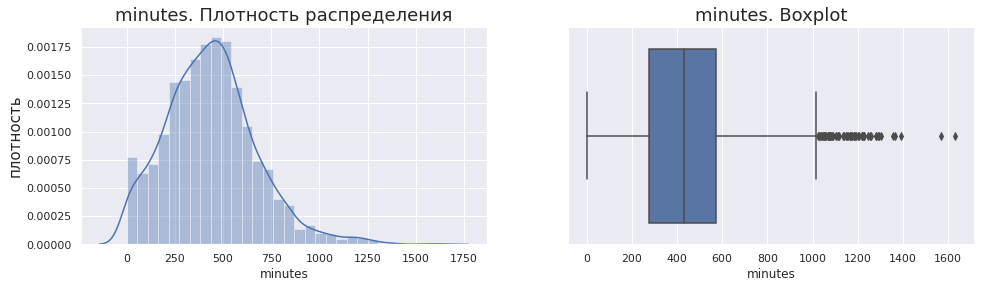

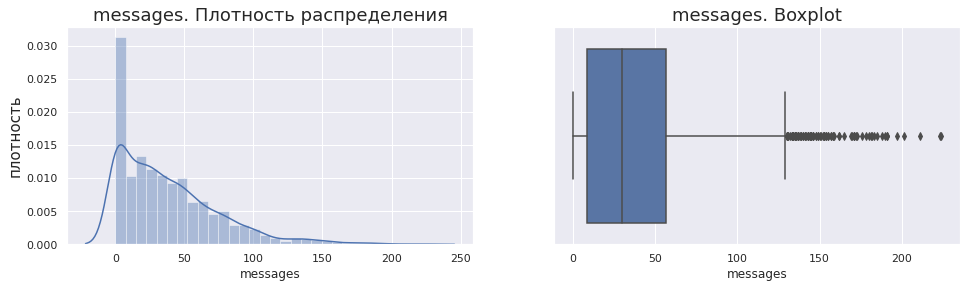

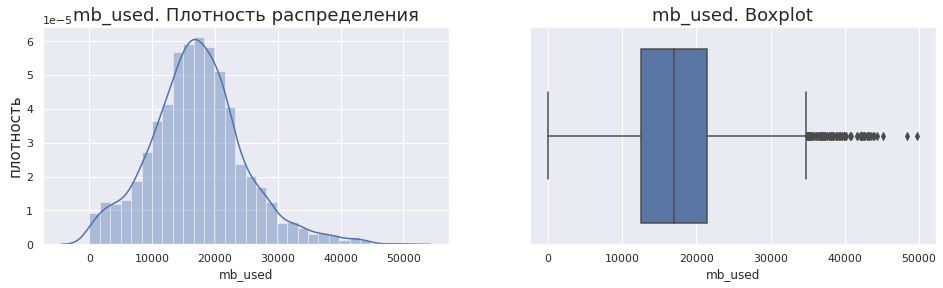

In [7]:
for column in users.drop('is_ultra', axis=1).columns:
    show_hists(users[column], column, num_bins=30)

- messages существенная доля пользователей не отправляющих сообщения

In [8]:
zero_mes_rate = round(len(users.loc[users['messages'] == 0]) / len(users) * 100, 2)
print('Доля пользователей, не отправляющих сообщения: {} %'.format(zero_mes_rate))

Доля пользователей, не отправляющих сообщения: 15.46 %


- определим доли выбросов по всем признакам

In [9]:
def outliers_rate(data, column):
    """
    input: data - таблица данных
           column - признак для подсчета доли выбросов
    output: None
    description: Функция считает и выводит долю выбросов по выбранному признаку в %.
                 функция возвращает значение границы выбросов.
    """
    # квантили считаются методом quantile()
    # граница выбросов считается по формуле  [ q.75 + (q.75 - q.25)*1.5 ]
    max_val = (data[column].quantile(0.75) - data[column].quantile(0.25))*1.5 + data[column].quantile(0.75)
    rate = round(len(data.loc[data[column] > max_val]) / len(data) * 100, 2)
    print('Доля выбросов в параметре {}: {} %'.format(column, rate))
    return max_val

In [10]:
# в переменной max_vals будем хранить границы выбросов по признакам
max_vals = []
# считаем границы выбросов по всем признакам и выводим доли выбросов по отдельным признакам
for column in users.drop('is_ultra', axis=1).columns:
    max_vals.append(outliers_rate(users, column))

# считаем общую долю выбросов по всем признакам.
whole_rate = len(users.loc[(users['calls'] > max_vals[0]) | 
                (users['minutes'] > max_vals[1]) | 
                (users['messages'] > max_vals[2]) | 
                (users['mb_used'] > max_vals[3]) 
                          ]) / len(users)
print('Общая доля выбросов: {} %'.format(round(whole_rate*100, 2)))

Доля выбросов в параметре calls: 1.93 %
Доля выбросов в параметре minutes: 1.9 %
Доля выбросов в параметре messages: 2.83 %
Доля выбросов в параметре mb_used: 2.4 %
Общая доля выбросов: 6.47 %


Выбросов около 6.5%. Не будем их удалять.

<font size = 4> **Выводы**</font>

- Данные успешно загружены и проанализированы. 
- Таблица данных содержит 3214 объектов, пропусков нет.
- Типы данных признаков calls и messages заменены на целочисленный int64.
- Сильного перекоса в распределениях признаков не наблюдается.
- Общая доля выбросов составляет 6.5%. Выбросы не удалены.

## Делим данные на выборки

Для корректной проверки будущей модели нам необходимо разбить данные на 3 выборки - обучающую, валидационную и тестовую.
Сначала отделим от датасета 60% наблюдений - это будет обучающая выборка. Оставщиеся данные поделим пополам - на тестовую и валидационную выборки. Таким образом мы разобьем данные в соотношении 60/20/20.

In [11]:
users_train, users_test = train_test_split(users, test_size=0.4, random_state=12345)
users_test, users_valid = train_test_split(users_test, test_size=0.5, random_state=12345)


In [12]:
users_train.shape

(1928, 5)

In [13]:
users_test.shape

(643, 5)

In [14]:
users_valid.shape

(643, 5)

<font size=4> **Вывод:** </font>

Разделили данные на три выборки в соотношении 60/20/20 соответственно:

- users_train - обучающая
- users_test - тестовая
- users_valid - валидационная

## Исследуем модели

Подготовим данные и обучим модель, а затем исследуем качество разных моделей, меняя гиперпараметры.

In [15]:
#подготовим признаки и целевой признак обучающей и валидационной выборок
features_train = users_train.drop(['is_ultra'], axis=1)
target_train = users_train['is_ultra']

In [16]:
features_valid = users_valid.drop(['is_ultra'], axis=1)
target_valid = users_valid['is_ultra']

### Решающее дерево

DecisionTreeClassifier

In [17]:
#исследуем работу модели с различными значениями гиперпараметра max_depth
for depth in range(3, 7, 1):
    model1 = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model1.fit(features_train, target_train)
    predictions_train = model1.predict(features_train)
    predictions_valid = model1.predict(features_valid)
    print("Accuracy при max_depth =", depth)
    print("Обучающая выборка:", accuracy_score(target_train, predictions_train))
    print("Валидационная выборка:", accuracy_score(target_valid, predictions_valid))
    print()

Accuracy при max_depth = 3
Обучающая выборка: 0.8075726141078838
Валидационная выборка: 0.7791601866251944

Accuracy при max_depth = 4
Обучающая выборка: 0.8106846473029046
Валидационная выборка: 0.7744945567651633

Accuracy при max_depth = 5
Обучающая выборка: 0.8200207468879668
Валидационная выборка: 0.7838258164852255

Accuracy при max_depth = 6
Обучающая выборка: 0.8376556016597511
Валидационная выборка: 0.776049766718507



### Случайный лес

RandomForestClassifier

In [18]:
#исследуем работу модели с различными значениями гиперпараметра n_estimators
for estim in range(2, 6, 1):
    model2 = RandomForestClassifier(random_state=123, n_estimators=estim)
    model2.fit(features_train, target_train)
    predictions_train2 = model2.predict(features_train)
    predictions_valid2 = model2.predict(features_valid)
    print("Accuracy при n_estimators =", estim)
    print("Обучающая выборка:", accuracy_score(target_train, predictions_train2))
    print("Валидационная выборка:", accuracy_score(target_valid, predictions_valid2))
    print()

Accuracy при n_estimators = 2
Обучающая выборка: 0.9118257261410788
Валидационная выборка: 0.7713841368584758

Accuracy при n_estimators = 3
Обучающая выборка: 0.9507261410788381
Валидационная выборка: 0.7822706065318819

Accuracy при n_estimators = 4
Обучающая выборка: 0.9413900414937759
Валидационная выборка: 0.7729393468118196

Accuracy при n_estimators = 5
Обучающая выборка: 0.9626556016597511
Валидационная выборка: 0.7931570762052877



###  Логистическая регрессия

LogisticRegression

In [19]:
model3 = LogisticRegression(random_state=123, solver='lbfgs')



In [20]:
model3.fit(features_train, target_train)


LogisticRegression(random_state=123)

In [21]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


LogisticRegression(multi_class='warn', random_state=123)

In [22]:
predictions_train3 = model3.predict(features_train)
predictions_valid3 = model3.predict(features_valid)


In [23]:
print("Обучающая выборка:", accuracy_score(target_train, predictions_train3))
print("Валидационная выборка:", accuracy_score(target_valid, predictions_valid3))

Обучающая выборка: 0.7131742738589212
Валидационная выборка: 0.6842923794712286


 <font size=4>**Вывод:**</font>

Модель случайного леса  отработала лучше двух других моделей.
При увеличении значения max_depth у модели решающего дерева луший резельтат работы на значении 5,
в случае с RandomForestClassifier остановимся на значении n_estimators=5, которое дало наилучший результат на валидационной выборке.
Логистическая регрессия показала низкий уровень точности, ниже 0,75.

## Проверяем модель на тестовой выборке

По критерию accuracy наилучшей точности удалось достичь с моделью Случайного леса  
Наилучшая точность: 0.79  
Парамтеры модели: n_estimators = 5  
Проведём обучение данной модели на всех доступных данных (обучающие + валидационные) и вычислим точность на тестовой выборке.

Объедим обучающую и валидационную выборки, а затем снова обучим модель перед тестовой проверкой.

In [24]:
features_merged = (users_train
                   .drop(['is_ultra'], axis=1)
                   .append([users_valid
                            .drop(['is_ultra'], axis=1)])
                  )
target_merged = users_train['is_ultra'].append([users_valid['is_ultra']])

In [25]:
features_test = users_test.drop(['is_ultra'], axis=1)
target_test = users_test['is_ultra']

RandomForestClassifier

In [26]:
#точность при обучении на объединенной выборке
model2 = RandomForestClassifier(random_state=123, n_estimators=5)
model2.fit(features_merged, target_merged)
model2.predict(features_test)
model2.score(features_test, target_test)

0.7620528771384136

In [27]:
#точность при обучении только на обучающей выборке
model2 = RandomForestClassifier(random_state=123, n_estimators=5)
model2.fit(features_train, target_train)
model2.predict(features_test)
model2.score(features_test, target_test)

0.7651632970451011

<font size=4>Вывод:</font>

На тестовой выборке модель RandomForestClassifier сработала хуже, но остается в рамках допустимой точности 0,75. 

Точность модели RandomForestClassifier на тесте для объединенной и обучающей выборки 0,76. Получается, что модель ошибается примерно в двух случаях из десяти.


## Проверка модели на адекватность

Для модели случайного леса посмотрим подробнее на зависимость точности от числа деревьев и максимальной глубины дерева.

Сравним наши лучшие модели с так называемым Dummy классификатором.   В случае, если точность наших моделей будет выше, значит их предсказания точнее случайного угадывания  
Обучим модель Dummy классификатора и проверим его accuracy, для чего напишем функцию, которая принимает на вход тип гиперпараметра strategy, обучающую выборку и тестовую, а возвращает значение accuracy

In [28]:
def train_fit_predict_dummy(features_train, target_train, features_test, target_test, strategy):
    dummy_model = DummyClassifier(random_state=123, strategy=strategy)
    dummy_model.fit(features_train, target_train)
    dummy_predictions = dummy_model.predict(features_test)
    dummy_accuracy = accuracy_score(target_test, dummy_predictions)
    return dummy_accuracy

Проверим теперь accuracy Dummy классификатора со следующими возможными значениями гиперпараметра strategy:

- stratified
- most_frequent
- prior
- uniform

In [29]:
strategies = ['stratified', 'most_frequent', 'prior', 'uniform']
for strategy in strategies:    
    test_accuracy = train_fit_predict_dummy(features_train, target_train, features_test, target_test, strategy=strategy)
    print('Accuracy для Dummy классификатора со стратегией', strategy, 'на тестовой выборке:', test_accuracy)

Accuracy для Dummy классификатора со стратегией stratified на тестовой выборке: 0.567651632970451
Accuracy для Dummy классификатора со стратегией most_frequent на тестовой выборке: 0.7060653188180405
Accuracy для Dummy классификатора со стратегией prior на тестовой выборке: 0.7060653188180405
Accuracy для Dummy классификатора со стратегией uniform на тестовой выборке: 0.4867807153965785


С учётом полученных значений accuracy для Dummy классификатора, можем сказать, что модели дерева решений и случайного леса прошли проверку, т.к. их значение точности больше, чем точность случайного угадывания

## Общий вывод

- Данные успешно загружены и проанализированы.
Пропусков не обнаружено, типы данных преобразованы в соответствии с хранимой информацией.
Сильного перекоса в распределениях признаков не наблюдается.
Общая доля выбросов составляет 6.5%. Выбросы не удалены.
- Были проанализированы различные классификационные модели: Решающее дерево, Случайный лес, Логистическая регрессия. Модели обучены на различных сочетаниях гиперпараметров.Нашли оптимальные, значение accuracy которых оказалось наивысшим. Также мы выбрали модели, которые удовлетворяют условию задачи, а именно имеют значение точности больше 0.75

Наилучшая точность (accuracy) была достигнута для модели Случайного леса:
- Accuracy на вадидационной выборке: 0.79
- Accuracy на тестовой тоже удовлетворяет условию 0.76

Модель Решающего дерева также удовлетворяет условию, но по качеству ниже Случайного леса.
Модель логистической регрессии не справилась с задачей, показав точность в 0.7 на валидационной выборке.
